Files already downloaded and verified
Files already downloaded and verified
Epoch 1 completed, loss: 0.712, accuracy: 0.897
Epoch 2 completed, loss: 0.264, accuracy: 0.962
Epoch 3 completed, loss: 0.145, accuracy: 0.980
Epoch 4 completed, loss: 0.115, accuracy: 0.984
Epoch 5 completed, loss: 0.079, accuracy: 0.989
Epoch 6 completed, loss: 0.046, accuracy: 0.994
Epoch 7 completed, loss: 0.060, accuracy: 0.992
Epoch 8 completed, loss: 0.028, accuracy: 0.996
Epoch 9 completed, loss: 0.057, accuracy: 0.996
Epoch 10 completed, loss: 0.101, accuracy: 0.988


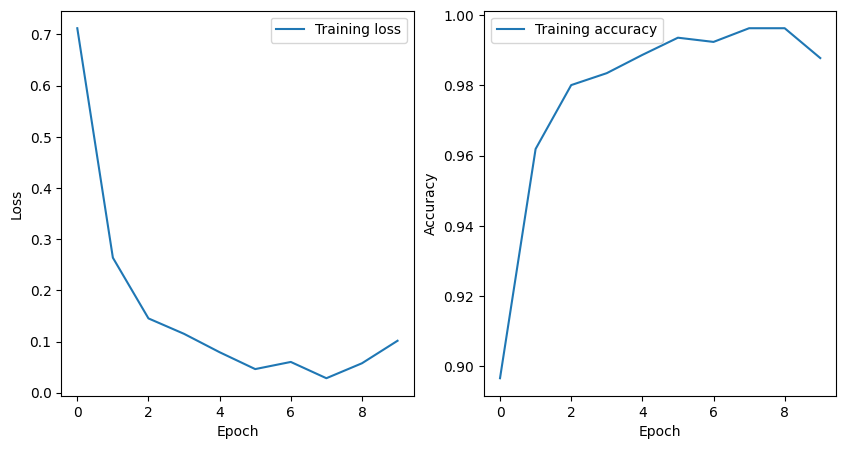

Test accuracy: 0.974


In [2]:
# Import the necessary modules
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the hyperparameters
batch_size = 128
num_epochs = 10
learning_rate = 0.01
margin = 1.0 # margin for triplet loss

# Load the CIFAR10 dataset and select only airplanes and cars classes
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset.targets = torch.tensor(trainset.targets)
trainset.data = trainset.data[trainset.targets <= 1]
trainset.targets = trainset.targets[trainset.targets <= 1]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testset.targets = torch.tensor(testset.targets)
testset.data = testset.data[testset.targets <= 1]
testset.targets = testset.targets[testset.targets <= 1]
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('airplane', 'car')

# Define the ResNet model and modify the last fully connected layer
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

# Move the model to the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss functions and the optimizer
criterion_ce = nn.CrossEntropyLoss() # cross entropy loss
criterion_tl = nn.TripletMarginLoss(margin=margin) # triplet loss
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Define a function to generate triplets from a batch of images and labels
def generate_triplets(images, labels):
  # Initialize the lists of anchor, positive and negative images
  anchor_images = []
  positive_images = []
  negative_images = []
  # Loop through the batch
  for i in range(len(labels)):
    # Find the indices of images that have the same label as the current image
    positive_indices = (labels == labels[i]).nonzero().flatten()
    # Find the indices of images that have a different label from the current image
    negative_indices = (labels != labels[i]).nonzero().flatten()
    # Randomly select a positive index and a negative index
    positive_index = positive_indices[torch.randint(len(positive_indices), (1,))].item()
    negative_index = negative_indices[torch.randint(len(negative_indices), (1,))].item()
    # Append the corresponding images to the lists
    anchor_images.append(images[i])
    positive_images.append(images[positive_index])
    negative_images.append(images[negative_index])
  # Stack the lists of images into tensors
  anchor_images = torch.stack(anchor_images)
  positive_images = torch.stack(positive_images)
  negative_images = torch.stack(negative_images)
  # Return the triplets of images
  return anchor_images, positive_images, negative_images

# Train the model
train_loss = [] # list to store the training loss
train_acc = [] # list to store the training accuracy
for epoch in range(num_epochs):
  running_loss = 0.0 # running loss for each epoch
  correct = 0 # number of correct predictions for each epoch
  total = 0 # total number of predictions for each epoch
  for i, data in enumerate(trainloader, 0):
    # Get the inputs and labels
    inputs, labels = data
    # Generate the triplets of images
    anchor_images, positive_images, negative_images = generate_triplets(inputs, labels)
    # Move the inputs and labels to the device
    inputs = inputs.to(device)
    labels = labels.to(device)
    anchor_images = anchor_images.to(device)
    positive_images = positive_images.to(device)
    negative_images = negative_images.to(device)
    # Zero the parameter gradients
    optimizer.zero_grad()
    # Forward pass
    outputs = model(inputs)
    anchor_outputs = model(anchor_images)
    positive_outputs = model(positive_images)
    negative_outputs = model(negative_images)
    # Compute the losses
    loss_ce = criterion_ce(outputs, labels)
    loss_tl = criterion_tl(anchor_outputs, positive_outputs, negative_outputs)
    loss = loss_ce + loss_tl # total loss
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    # Print statistics
    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    if i % 200 == 199: # print every 200 mini-batches
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 200))
      running_loss = 0.0
  # Append the epoch loss and accuracy to the lists
  train_loss.append(running_loss / len(trainloader))
  train_acc.append(correct / total)
  print('Epoch %d completed, loss: %.3f, accuracy: %.3f' %
        (epoch + 1, train_loss[-1], train_acc[-1]))

# Plot the training loss and accuracy
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_acc, label='Training accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Test the model
model.eval() # set the model to evaluation mode
correct = 0 # number of correct predictions
total = 0 # total number of predictions
with torch.no_grad(): # disable gradient computation
  for data in testloader:
    # Get the inputs and labels
    inputs, labels = data
    # Move the inputs and labels to the device
    inputs = inputs.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = model(inputs)
    # Get the predictions
    _, predicted = torch.max(outputs.data, 1)
    # Update the statistics
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
# Print the test accuracy
print('Test accuracy: %.3f' % (correct / total))
